### lecture 15 - ARMA(p,q) and ARIMA(p,d,q)

#### Autoregressive Moving Averages
This section covers <em>Autoregressive Moving Averages</em> (ARMA) and <em>Autoregressive Integrated Moving Averages</em> (ARIMA).

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

STEPS TO FOLLOW: https://otexts.com/fpp2/arima-r.html

In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
df1 = pd.read_csv('./dataset/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'

In [32]:
df2 = pd.read_csv('./dataset/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

#### automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [33]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string()) # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

#### Autoregressive Moving Average - ARMA(p,q) model
In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the <em>Daily Total Female Births</em> dataset should work for our purposes.

<Axes: xlabel='Date'>

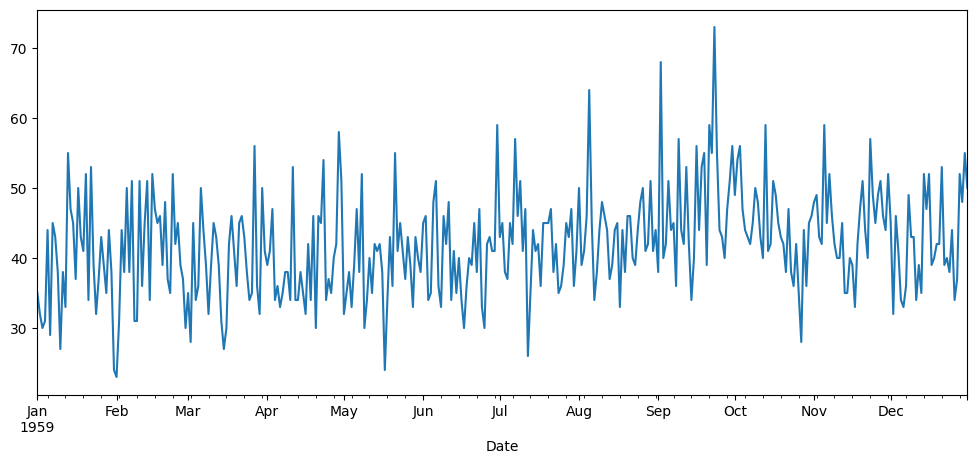

In [34]:
df1['Births'].plot(figsize=(12,5)) # no clear trend or seasonality

In [35]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


we can see that the p-value is extremely low so there are strong evidence against the null hypothesis and we reject the null hypothesis and we say that the data are stationary

In [36]:
auto_arima(df1['Births'], start_p=0,start_q=0,max_p=6,max_q=3,d=0, # d=0 since is a ARMA
                          seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3776.976, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2656.891, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3407.164, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2474.496, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2471.358, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2472.653, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2471.853, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2474.606, Time=0.42 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.462 seconds


ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

#### train and test set

In [37]:
train = df1.iloc[:292]

In [38]:
test = df1.iloc[292:]

In [39]:
model = ARIMA(train['Births'], order=(2,0,1)) 

In [40]:
result = model.fit()

In [41]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -987.482
Date:                Mon, 30 Dec 2024   AIC                           1984.964
Time:                        13:14:40   BIC                           2003.348
Sample:                    01-01-1959   HQIC                          1992.328
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.2848      5.301      7.977      0.000      31.895      52.674
ar.L1          1.0674      0.077     13.864      0.000       0.916       1.218
ar.L2         -0.0730      0.069     -1.052      0.2

In [42]:
start = len(train)

In [43]:
end = len(train) + len(test) -1

In [44]:
predictions = result.forecast(steps=len(test)).rename('ARMA predictions')

In [45]:
test.head()

,Births
Date,
1959-10-20,42
1959-10-21,38
1959-10-22,47
1959-10-23,38
1959-10-24,36


In [46]:
predictions.head()

1959-10-20    46.133315
1959-10-21    46.340468
1959-10-22    46.332748
1959-10-23    46.309379
1959-10-24    46.284999
Freq: D, Name: ARMA predictions, dtype: float64

<Axes: xlabel='Date'>

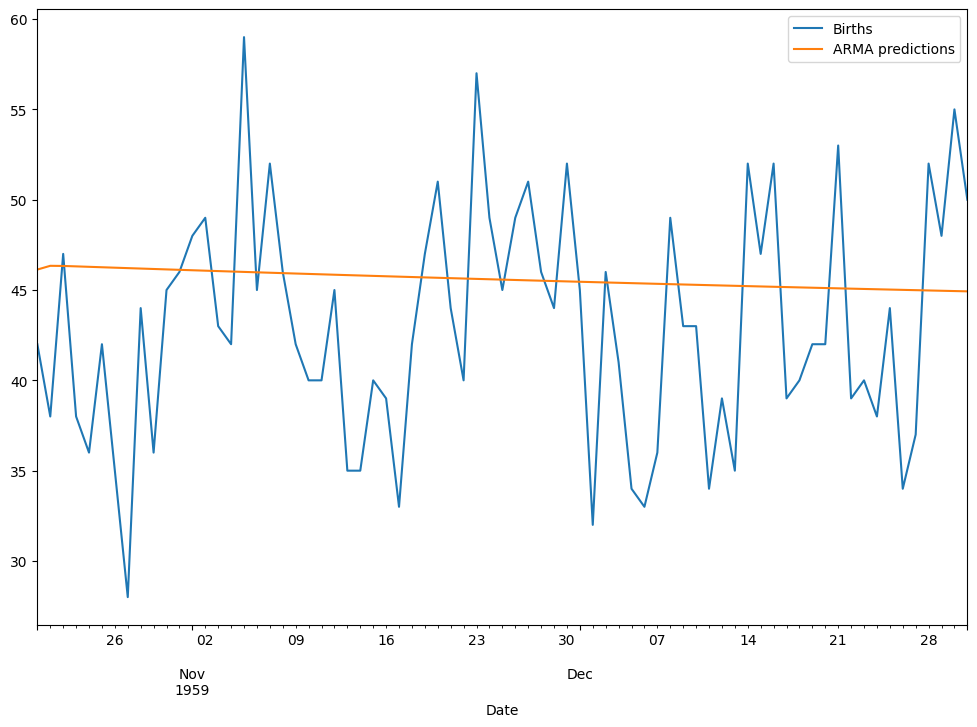

In [47]:
test['Births'].plot(figsize=(12,8),legend=True)
predictions.plot(legend=True)

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. The predictions are showing the forecasted average value

In [48]:
test.mean()

Births    43.027397
dtype: float64

In [49]:
predictions.mean() 

45.59928790541565

extremely close to the mean of the test set. so our model, while not being able to predict the noise that happened during these dates it was able to correctly predict extremely close to the actual mean average for the next month data

#### Autoregressive Integrated Moving Average - ARIMA(p,d,q) model
The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.<br>
First let's take a look at the <em>Real Manufacturing and Trade Inventories</em> dataset.

<Axes: xlabel='Date'>

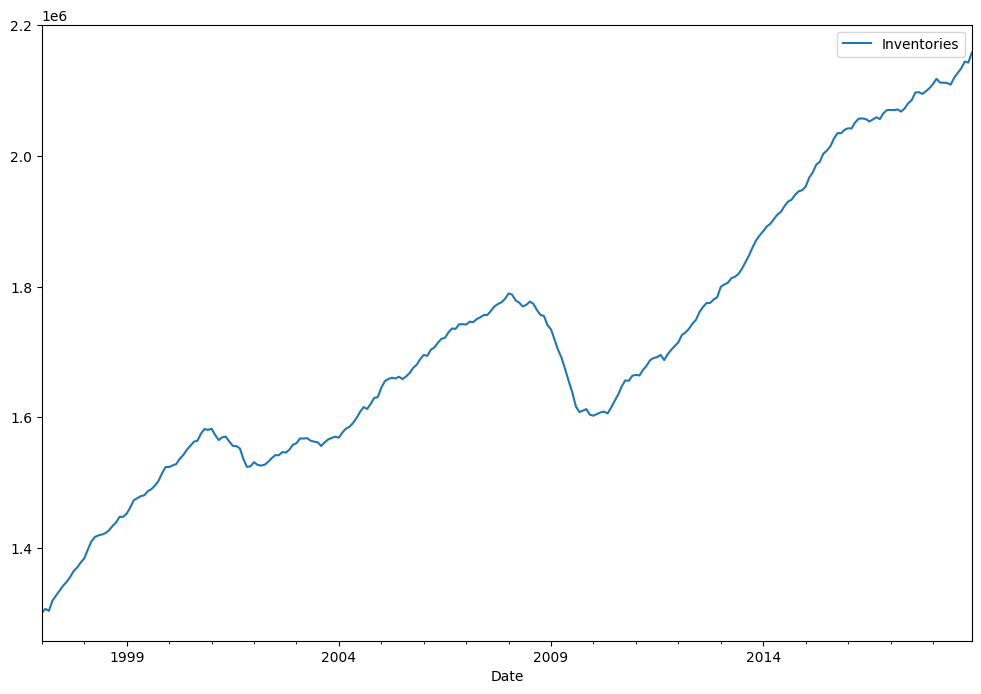

In [50]:
df2.plot(figsize=(12,8))

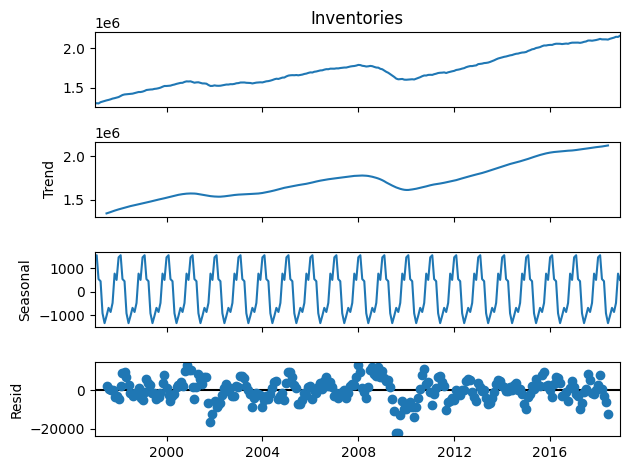

In [51]:
result = seasonal_decompose(df2['Inventories'], model='additive') # model='add' also works
result.plot();

In [58]:
auto_arima(df2['Inventories'],start_p=0,start_q=0,max_p=6,max_q=3,
                          seasonal=False,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.995 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Mon, 30 Dec 2024   AIC                           5348.037
Time:                        13:15:16   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
from statsmodels.tsa.statespace.tools import diff

In [54]:
df2['Diff_1'] = diff(df2['Inventories'],k_diff=1)

In [55]:
adf_test(df2['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


so now data are stationary after differencing by 1

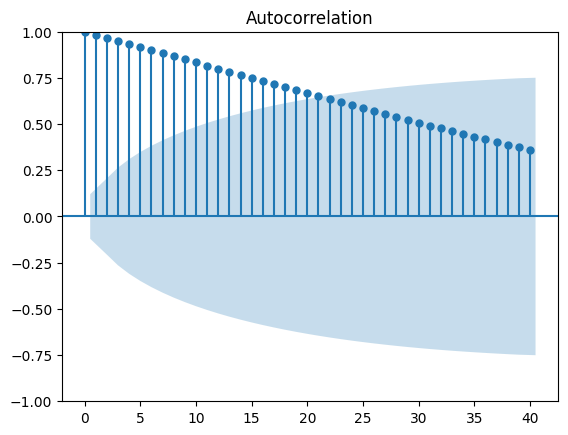

In [56]:
plot_acf(df2['Inventories'],lags=40);

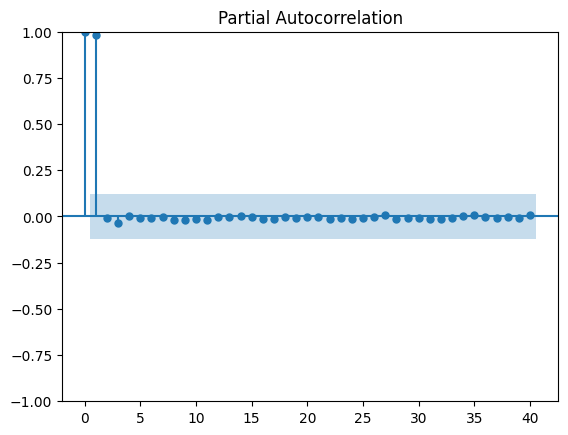

In [57]:
plot_pacf(df2['Inventories'],lags=40);

#### determine AR term manually

If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms. 

So that implies tht the AR component should be one by looking at the PACF plot

#### AR and MA signatures

* ACF that dies out gradually and PACF that cuts off
sharply after a few lags --> AR signature, meaning that the autocorrelation pattern can be ecplained more easily by adding AR terms rather than MA terms
– An AR series is usually positively autocorrelated at lag 1
(or even borderline nonstationary) --> THIS SHOULD BE OUR CASE

* ACF that cuts off sharply after a few lags and PACF
that dies out more gradually --> MA signature
– An MA series is usually negatively autcorrelated at lag 1
(or even mildly overdifferenced)

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

So, through the classical method we should have:

* AR = 1
* I = 1
* MA = 0 or 1 depending on which gives back the lowest error

In [68]:
stepwise_fit = auto_arima(df2['Inventories'],start_p=0,
                          start_q=0,max_p=2,max_q=2,
                          seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.713 seconds


#### train and test set

In [69]:
len(df2)

264